In [99]:
import root_pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import seaborn as sns
from multiprocessing.pool import ThreadPool as Pool
import multiprocessing

%matplotlib inline
sns.set()

In [211]:
stats=pd.read_csv("deleteme.csv",delimiter=" ",header=None).iloc[:,[1,3,5,7]]

In [213]:
stats.columns = ["orientation","dataType","dataset","nentries"]

In [217]:
stats.groupby(["dataType","orientation"]).sum()

nentries
dataType orientation          
acc      000           3675401
         045           3472097
         090           3499507
         135           3450854
         AMO           1442643
data     000            732386
         045            691725
         090            696743
         135            706602
         AMO            155428
gen      000          17663417
         045          16905025
         090          16968081
         135          16795617
         AMO           8143426

In [187]:
df = root_pandas.read_root("degALL_looseChiUE_treeFlat_DSelector.root",
                          columns=["Mpi0","Meta","unusedEnergy","chiSq",
                                   "AccWeight","weightASBS","weightBS","Mpi0eta"])

In [188]:
ellipseX=0.135881
ellipseY=0.548625
stdX=0.0076
stdY=0.0191
sigStdX=3
skipStdX=1
sbStdX=2
sigStdY=3
skipStdY=1
sbStdY=2

Text(0.5,0.98,'chiSq < 5 && Mpi0eta > 1.6 GeV')

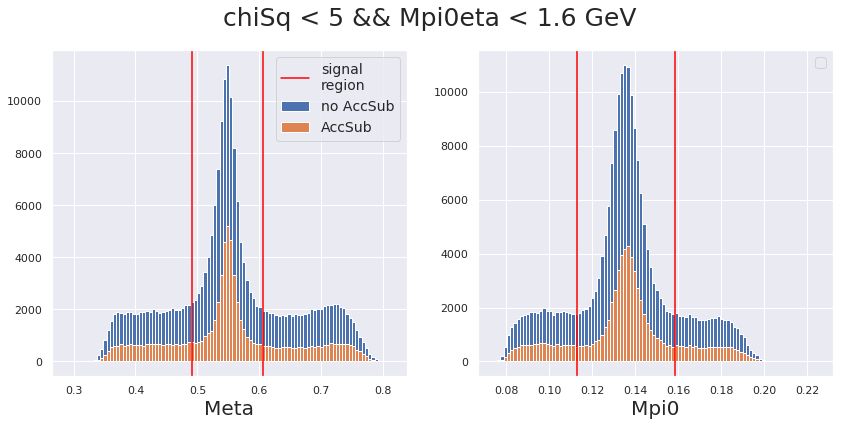

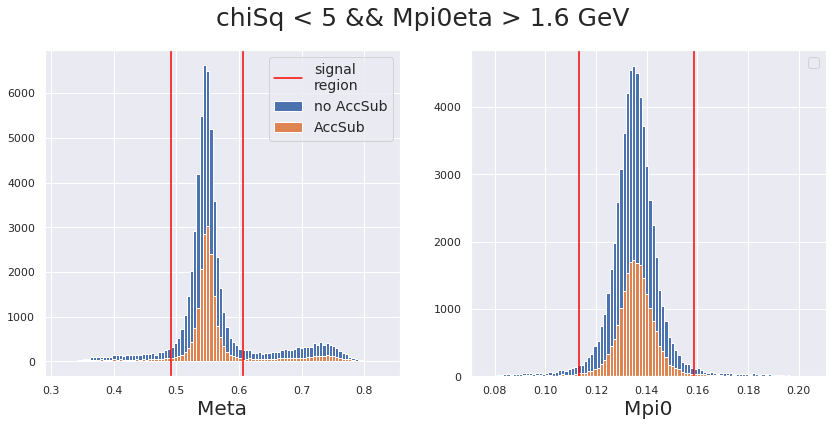

In [201]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
df_subset=df[(df.chiSq<5) & (df.unusedEnergy<0.01) &(df.Mpi0eta < 1.6)]

df_subset.Meta.hist(bins=100,ax=ax[0],label="no AccSub")
df_subset.Meta.hist(bins=100,ax=ax[0],weights=df_subset.AccWeight,label="AccSub")
ax[0].set_xlabel("Meta",size=20)
ax[0].axvline(ellipseY+stdY*sigStdY,c='red',label="signal\nregion")
ax[0].axvline(ellipseY-stdY*sigStdY,c='red')
ax[0].legend(prop={"size":14})

df_subset.Mpi0.hist(bins=100,ax=ax[1])
ax[1].set_xlabel("Mpi0",size=20)
df_subset.Mpi0.hist(bins=100,ax=ax[1],weights=df_subset.AccWeight)
ax[1].axvline(ellipseX+stdX*sigStdX,c='red')
ax[1].axvline(ellipseX-stdX*sigStdX,c='red')

ax[1].legend(prop={"size":14})
plt.suptitle("chiSq < 5 && Mpi0eta < 1.6 GeV",size=25)

fig, ax = plt.subplots(1,2,figsize=(14,6))
df_subset=df[(df.chiSq<5) & (df.unusedEnergy<0.01) &(df.Mpi0eta > 1.6)]

df_subset.Meta.hist(bins=100,ax=ax[0],label="no AccSub")
df_subset.Meta.hist(bins=100,ax=ax[0],weights=df_subset.AccWeight,label="AccSub")
ax[0].set_xlabel("Meta",size=20)
ax[0].axvline(ellipseY+stdY*sigStdY,c='red',label="signal\nregion")
ax[0].axvline(ellipseY-stdY*sigStdY,c='red')
ax[0].legend(prop={"size":14})

df_subset.Mpi0.hist(bins=100,ax=ax[1])
ax[1].set_xlabel("Mpi0",size=20)
df_subset.Mpi0.hist(bins=100,ax=ax[1],weights=df_subset.AccWeight)
ax[1].axvline(ellipseX+stdX*sigStdX,c='red')
ax[1].axvline(ellipseX-stdX*sigStdX,c='red')

ax[1].legend(prop={"size":14})
plt.suptitle("chiSq < 5 && Mpi0eta > 1.6 GeV",size=25)

In [4]:
selectionVars=["unusedEnergy","chiSq"]
nSelectionVars=len(selectionVars)

discrimVars=["Mpi0","Meta"]
nDiscrimVars=len(discrimVars)

statNames=["sigYield","bkgYield","purity"]
nStats=len(statNames)

In [5]:
def buildSubplots(nColsPlot,nVars):
    nRows=int(nVars/nColsPlot)+int(nVars%nColsPlot>0)
    fig, axes = plt.subplots(nRows,nColsPlot,figsize=(16,nRows*6))
    axes=axes.flatten()
    return fig,axes

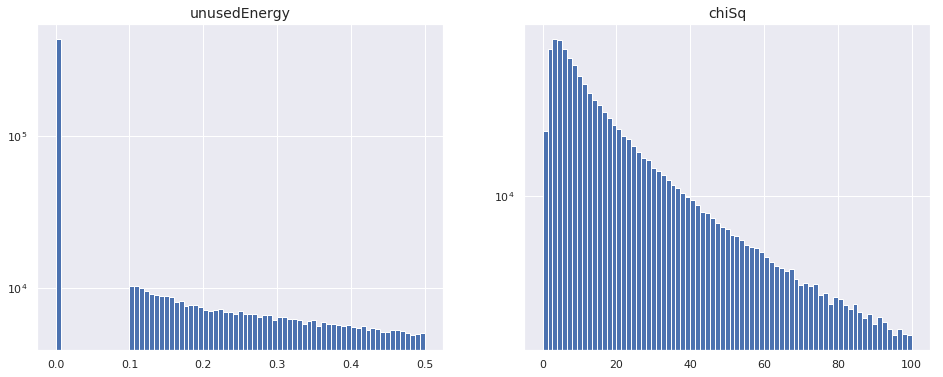

In [6]:
fig, axes=buildSubplots(2,nSelectionVars)
for iax, selectionVar in enumerate(selectionVars):
    df[selectionVar].hist(bins=75,weights=df.AccWeight,ax=axes[iax])
    axes[iax].set_title(selectionVar,size=14)
    axes[iax].set_yscale("log")

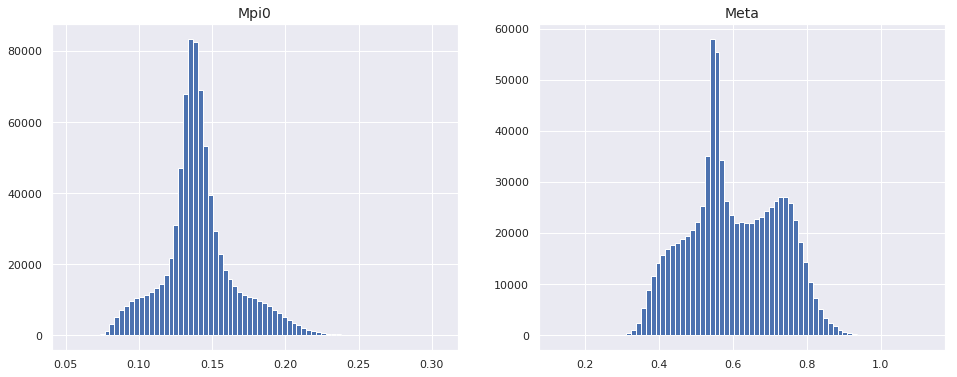

In [7]:
fig, axes=buildSubplots(2,nDiscrimVars)
for iax, discrimVar in enumerate(discrimVars):
    df[discrimVar].hist(bins=75,weights=df.AccWeight,ax=axes[iax])
    axes[iax].set_title(discrimVar,size=14)

In [8]:
mins=[]
maxs=[]
for iVar, selectionVar in enumerate(selectionVars):
    maxs.append(df[selectionVar].max())
    mins.append(df[selectionVar].min())

In [9]:
def getThresholds():
    thresholds=[]
    selection=True
    for iVar, selectionVar in enumerate(selectionVars):
        criteria=np.random.uniform(mins[iVar],maxs[iVar])
        thresholds.append(criteria)
        selection = selection & (df[selectionVar] <= criteria)
    return thresholds, selection

In [80]:
def determineQuality(selection):
    sigBool=df["weightBS"]==1
    bkgBool=(df["weightBS"]!=1) & (df["weightBS"]!=0)
    sigYield=df[sigBool & selection].weightASBS.sum()
    bkgYield=-1*df[bkgBool & selection].weightASBS.sum()
    purity=sigYield/(sigYield+bkgYield)
    return sigYield,bkgYield,purity

In [11]:
def convertDouble(var):
    return '{0:.2f}'.format(var)

In [12]:
def getDiagPlots():
    fig, axes=buildSubplots(2,nDiscrimVars)
    title=map(convertDouble,thresholds)
    title="\n".join([a+"< "+b for a,b in zip(selectionVars,title)])
    plt.suptitle(title,size=18)
    fig.subplots_adjust(top=0.8)
    for i,discrimVar in enumerate(discrimVars):
        df.loc[selection,discrimVar].hist(bins=75,ax=axes[i],weights=df.loc[selection,"AccWeight"])
        axes[i].set_title(discrimVar,size=14)

    statBox=map(convertDouble,stats)
    statBox="\n".join([a+":"+b for a,b in zip(statNames,statBox)])
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    axes[0].text(0.6, 0.95, statBox, transform=axes[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

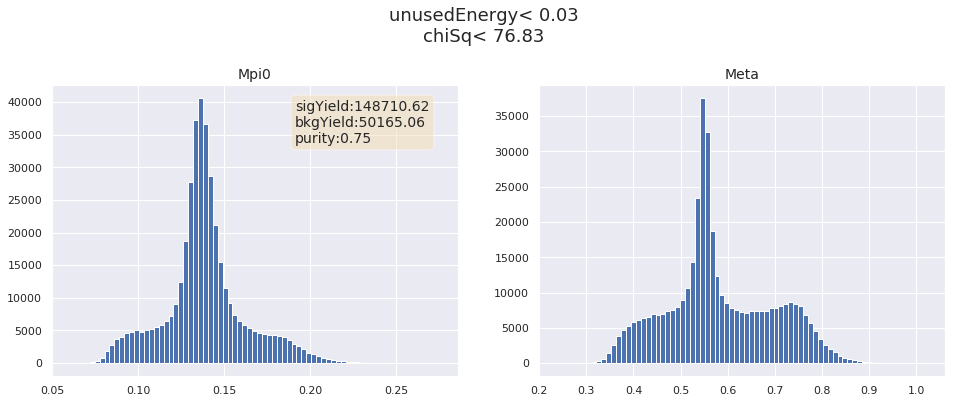

In [14]:
thresholds, selection = getThresholds()
stats = determineQuality()
getDiagPlots()

In [128]:
nPoints=500
statPoints=nSelectionVars+nStats
df_quality=np.zeros([nPoints,statPoints])
# for i in range(nPoints):
#     thresholds, selection = getThresholds()
#     stats = determineQuality()
#     df_quality[i]=np.array(thresholds+list(stats))
# colNames=[a+"Thresh" for a in selectionVars]+statNames
# df_quality=pd.DataFrame(df_quality, columns=colNames)

In [129]:
def analyze(i):
    thresholds, selection = getThresholds()
    stats = determineQuality(selection)
    return np.array(thresholds+list(stats))

In [140]:
pool=Pool(processes=2)
df_quality=pool.map(analyze,range(nPoints))
pool.terminate()

CPU times: user 54.4 s, sys: 5.99 s, total: 1min
Wall time: 1min


In [142]:
colNames=[a+"Thresh" for a in selectionVars]+statNames
df_quality=pd.DataFrame(df_quality, columns=colNames)

In [95]:
def plotMesh(x,y,zArray,nLevels):
    fig, axes=buildSubplots(2,len(zArray))
    for i,z in enumerate(zArray):
        axes[i].tricontour(x, y, z, nLevels, linewidths=0.5, colors='k')
        axes[i].set_ylabel("chiSq",size=14)
        axes[i].set_xlabel("unusedEnergy",size=14)
        axes[i].set_title(z.name,size=18)
        contour = axes[i].tricontourf(x, y, z, nLevels)
        fig.colorbar(contour, ax=axes[i])
    plt.tight_layout()

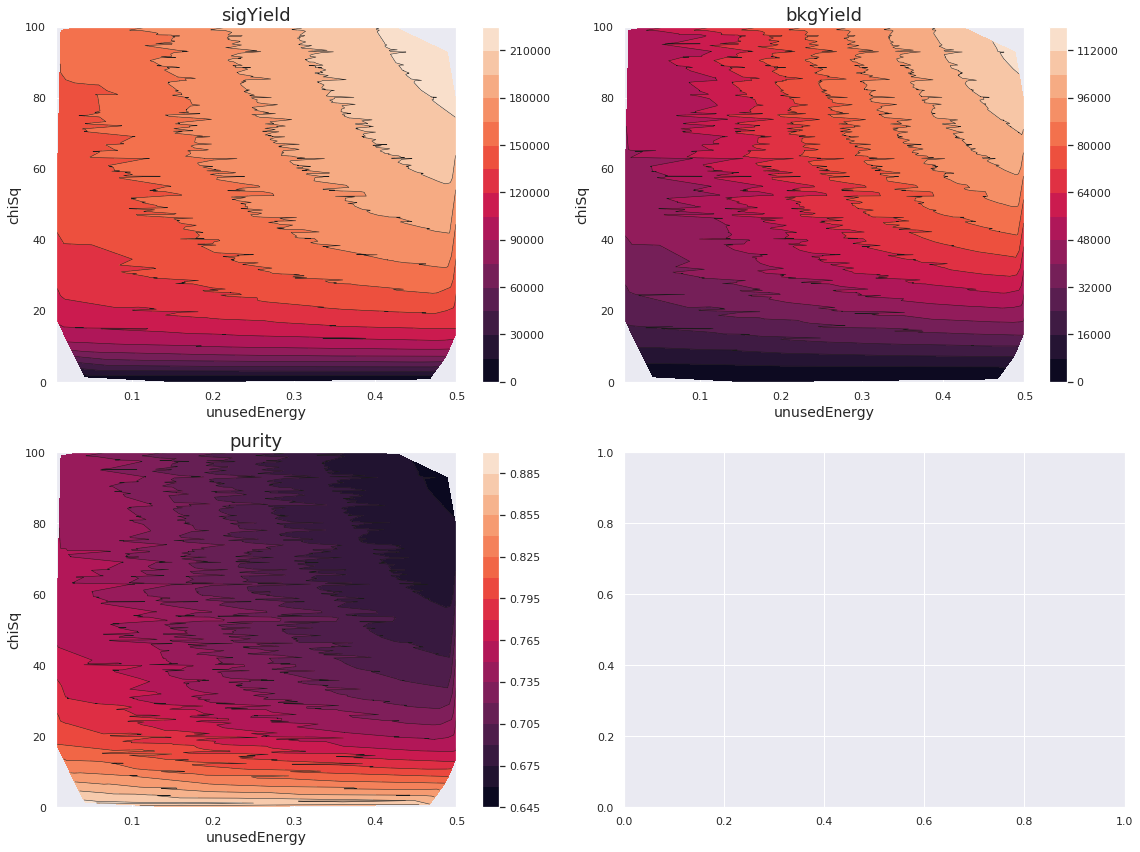

In [96]:
plotMesh(
    df_quality.unusedEnergyThresh,
    df_quality.chiSqThresh,
    [df_quality.sigYield,df_quality.bkgYield,df_quality.purity],
    15
)

In [97]:
df_quality[df_quality.unusedEnergyThresh<0.01].sort_values(by="chiSqThresh")

,unusedEnergyThresh,chiSqThresh,sigYield,bkgYield,purity
247,0.006589,18.348329,111834.250,26465.06250,0.808639
120,0.007530,47.103763,139521.875,43318.50000,0.763080
210,0.007817,48.770025,140298.000,43898.90625,0.761674
